# SAM (Segment Anything Model) - Parasite Segmentation Pipeline

This notebook implements an end-to-end pipeline for segmenting parasites in museum specimen images using Meta's Segment Anything Model (SAM).

## Pipeline Overview:
1. **Setup & Data Loading**: Clone repository and load images
2. **Preprocessing**: Apply CLAHE, extract specimen ROI, remove background
3. **Tiling**: Split large images into manageable tiles (~20 per image)
4. **SAM Segmentation**: Use point prompts to segment parasites in each tile
5. **Reconstruction**: Reassemble tiles into full-resolution masks
6. **Export**: Save binary masks (white parasites on black background)

---

## 1. Setup Environment

Clone the project repository and navigate to the working directory containing:
- Raw specimen images (`.JPG`)
- Label masks with parasite annotations (`_labels.png` or `_labels.JPG`)

In [1]:
import os
!git clone https://github.com/ia-project-parasite/IA-PROJECT-PARASITE-REPO.git
os.chdir('IA-PROJECT-PARASITE-REPO')
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q opencv-python matplotlib pandas tqdm
!pip install -q scikit-image pillow

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import json
import random
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from skimage.morphology import remove_small_holes, remove_small_objects
from skimage.color import label2rgb
from skimage.measure import regionprops_table
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
from segment_anything.utils.transforms import ResizeLongestSide
import torchvision.transforms as T


Cloning into 'IA-PROJECT-PARASITE-REPO'...
remote: Enumerating objects: 195, done.
remote: Total 195 (delta 0), reused 0 (delta 0), pack-reused 195 (from 1)
Receiving objects: 100% (195/195), 439.05 MiB | 35.70 MiB/s, done.
Resolving deltas: 100% (71/71), done.
Updating files: 100% (106/106), done.
  Preparing metadata (setup.py) ... done


## 2. Core Functions for Image Preprocessing

### Functions defined:

#### `specimen_mask(bgr, use_hull=False)`
Creates a binary mask of the specimen using HSV thresholding:
- Converts image to HSV color space
- Applies adaptive thresholding on Value and Saturation channels
- Cleans mask with morphological operations (open/close)
- Keeps only the largest connected component (the specimen)
- Optionally applies convex hull for smoother boundaries

#### `split_image_into_tiles(img, points, roi_mask, n_tiles=20)`
Divides the image into non-overlapping tiles:
- Calculates grid dimensions based on target number of tiles
- Creates tiles with NO overlap (exact divisions)
- Assigns parasite points to their respective tiles
- Converts point coordinates to tile-local coordinate system
- **NOW KEEPS ALL TILES** - even those without parasites (useful for negative examples)

#### `process_image_with_tiling(image_path, label_path, image_id, ...)`
Complete preprocessing pipeline:
1. Reads raw image and label mask
2. Applies CLAHE exposure correction (optional)
3. Creates specimen mask and blacks out background
4. **IMPORTANT**: Does NOT crop - keeps original image dimensions
5. Extracts parasite point coordinates from label mask
6. Splits image into tiles with metadata

#### `get_white_points_and_crop(mask)`
Extracts parasite locations from label masks:
- Uses connected component analysis
- Each white blob = one parasite
- Calculates centroid of each blob as the point coordinate

In [4]:
# Import preprocessing functions from preprocessing.py
from preprocessing import correct_exposure
from skimage.morphology import remove_small_holes, remove_small_objects

def specimen_mask(bgr, use_hull=False):
    """
    Generate a binary mask for the specimen:
    1. Threshold value and saturation channels in HSV.
    2. Clean mask using morphological operations.
    3. Keep largest connected component.
    4. Optionally apply convex hull.
    """
    # Convert to HSV
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)

    # Adaptive threshold on brightness (V)
    ret, _ = cv2.threshold(V, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    v_thr, s_thr = int(max(ret * 0.7, 25)), 15
    m = ((V >= v_thr) & (S >= s_thr)).astype(np.uint8)

    # Morphological cleanup
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN, k)
    m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, k)
    m = remove_small_objects(m.astype(bool), min_size=3000)
    m = remove_small_holes(m, area_threshold=50000).astype(np.uint8)

    # Keep largest connected component
    n, lab = cv2.connectedComponents(m)
    if n <= 1:
        return np.zeros(m.shape, bool)
    cnts = np.bincount(lab.ravel())[1:]
    keep = 1 + np.argmax(cnts)
    m = (lab == keep).astype(np.uint8)

    # Optional convex hull for smoother mask
    if use_hull:
        contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            hull = cv2.convexHull(np.vstack(contours))
            m_hull = np.zeros_like(m)
            cv2.drawContours(m_hull, [hull], -1, 1, -1)
            m = m_hull

    return m.astype(bool)


def split_image_into_tiles(img, points, roi_mask=None, n_tiles=20):
    """
    Split image into approximately n_tiles NON-OVERLAPPING tiles.
    """
    h, w = img.shape[:2]
    side = int(np.sqrt(h * w / n_tiles))
    n_rows = max(1, h // side)
    n_cols = max(1, w // side)

    # Calculate actual tile dimensions to avoid overlap
    tile_h = h // n_rows
    tile_w = w // n_cols

    tiles = []
    assigned_points = set()  # Track which points have been assigned

    for i in range(n_rows):
        for j in range(n_cols):
            # Use exact divisions to prevent overlap
            y1 = i * tile_h
            x1 = j * tile_w

            # Last row/col gets remaining pixels
            if i == n_rows - 1:
                y2 = h
            else:
                y2 = (i + 1) * tile_h

            if j == n_cols - 1:
                x2 = w
            else:
                x2 = (j + 1) * tile_w

            # Extract tile image
            tile_img = img[y1:y2, x1:x2]

            # REMOVED: ROI coverage check - now keeps ALL tiles

            # Find points in this tile
            tile_points = []
            for idx, (x, y) in enumerate(points):
                if idx not in assigned_points and x1 <= x < x2 and y1 <= y < y2:
                    # Convert to tile-local coordinates
                    tile_points.append((x - x1, y - y1))
                    assigned_points.add(idx)

            # Save ALL tiles
            tiles.append({
                'image': tile_img,
                'points': tile_points,
                'tile_id': f"seg_{i}_{j}",
                'global_bbox': (x1, y1, x2, y2)
            })

    return tiles

def process_image_with_tiling(image_path, label_path, image_id, n_tiles=20, apply_clahe=True, extract_roi=True):
    """
    Complete preprocessing pipeline:
    1. Apply CLAHE (from preprocessing.py)
    2. Black out background outside specimen (WITHOUT cropping)
    3. Extract points from labels
    4. Split into tiles

    Args:
        extract_roi: If True, black out background outside specimen (keeps original dimensions)

    Returns:
        List of tile dictionaries
    """
    # Read image and label
    img = cv2.imread(image_path)
    label = cv2.imread(label_path)

    if img is None or label is None:
        print(f"Warning: Could not read {image_id}")
        return []

    # Apply CLAHE exposure correction
    if apply_clahe:
        img = correct_exposure(img)

    # Extract specimen mask and black out background (WITHOUT cropping)
    roi_mask = None

    if extract_roi:
        # Create specimen mask
        specimen_m = specimen_mask(img, use_hull=False)

        if specimen_m.sum() == 0:
            print(f"Warning: Could not create specimen mask for {image_id}")
            roi_mask = None
        else:
            # Black out background outside specimen WITHOUT cropping
            img = img.copy()
            img[~specimen_m] = 0  # Set all pixels outside specimen to black
            roi_mask = specimen_m

    # Extract points from label mask
    points, _ = get_white_points_and_crop(label)

    if points is None or len(points) == 0:
        print(f"Warning: No points found in {image_id}")
        return []

    # NO coordinate adjustment needed since we're not cropping!
    # Points remain in original coordinate system

    # Split into tiles
    tiles = split_image_into_tiles(img, points, roi_mask=roi_mask, n_tiles=n_tiles)

    # Add metadata to each tile
    for tile in tiles:
        tile['image_id'] = f"{image_id}_{tile['tile_id']}"
        tile['base_image_id'] = image_id
        tile['num_parasites'] = len(tile['points'])

    return tiles

def get_white_points_and_crop(mask):
    """
    Get centroid coordinates of white blobs (parasite markers).
    Each connected white region = 1 parasite point.
    """
    gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

    # Find connected components - each blob is one parasite
    num_labels, labels = cv2.connectedComponents(thresh)

    centers = []
    for label_id in range(1, num_labels):  # Skip background (label 0)
        # Get all pixels in this component
        component_mask = (labels == label_id)

        # Calculate centroid of this blob
        ys, xs = np.where(component_mask)
        center_x = int(xs.mean())
        center_y = int(ys.mean())
        centers.append((center_x, center_y))

    if len(centers) == 0:
        return None, None

    return centers, thresh

## 3. Process All Images and Create Tiles

This cell processes all images in the `Museum labels` directory:

### Processing steps:
1. **Find image pairs**: Looks for matching `.JPG` image and `_labels.png` files
2. **Apply preprocessing**: 
   - CLAHE exposure correction
   - Specimen extraction (blacks out background, keeps original dimensions)
3. **Create tiles**: Splits each image into ~20 non-overlapping tiles
4. **Track metadata**: Stores tile info including:
   - Image ID and base image ID
   - Global bounding box coordinates
   - Parasite point locations (in tile-local coordinates)
   - Number of parasites per tile

### Output:
- `all_tiles`: List of all tile dictionaries with images and metadata
- `tiles_per_image`: Dictionary showing how many tiles per image

In [5]:
# Process all images with complete preprocessing pipeline
museum_labels_dir = "Museum labels"
output_dir = "SAM_training_data"
os.makedirs(output_dir, exist_ok=True)

# Find all folders
folders = [f for f in os.listdir(museum_labels_dir)
           if os.path.isdir(os.path.join(museum_labels_dir, f))]

all_tiles = []
tiles_per_image = {}

for folder in tqdm(folders, desc="Processing images"):
    folder_path = os.path.join(museum_labels_dir, folder)

    # Look for raw image and label mask
    raw_img_path = os.path.join(folder_path, f"{folder}.JPG")
    label_mask_path = os.path.join(folder_path, f"{folder}_labels.png")

    if not os.path.exists(label_mask_path):
        label_mask_path = os.path.join(folder_path, f"{folder}_labels.JPG")

    if not os.path.exists(raw_img_path) or not os.path.exists(label_mask_path):
        continue

    tiles = process_image_with_tiling(
        raw_img_path,
        label_mask_path,
        folder,
        n_tiles=20,
        apply_clahe=True,
        extract_roi=True
    )

    all_tiles.extend(tiles)
    tiles_per_image[folder] = len(tiles)

print(f"\nProcessed {len(folders)} images")
print(f"\nGenerated {len(all_tiles)} tiles")
print(f"\nTotal parasites: {sum(t['num_parasites'] for t in all_tiles)}")
print(f"\nTiles per image: {tiles_per_image}")

Processing images: 100%|██████████| 6/6 [00:48<00:00,  8.01s/it]


Processed 6 images

Generated 75 tiles

Total parasites: 429

Tiles per image: {'B2025-00139a': 15, 'B2025-00142a': 15, 'B2025-00130c': 15, 'B2025-00130e': 15, 'B2025-00084n': 15}


## 4. Load SAM (Segment Anything Model)

### Model Setup:
- **Model**: `vit_b` (Vision Transformer Base) - good balance of speed and accuracy
- **Checkpoint**: Downloads pre-trained weights from Meta AI (~375MB)
- **Device**: Automatically uses GPU (CUDA) if available, otherwise CPU

### SAM Capabilities:
SAM can segment any object given:
- **Point prompts** (what we use): Click coordinates indicating objects
- Box prompts: Bounding boxes around objects
- Mask prompts: Rough initial masks to refine

We use point prompts from our label masks to tell SAM where parasites are located.

In [6]:
def load_sam_model(model_type="vit_b", checkpoint_path=None):
    if checkpoint_path is None:
        checkpoint_path = "sam_vit_b_01ec64.pth"

    if not os.path.exists(checkpoint_path):
        print("Downloading SAM checkpoint...")
        !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

    device = "cuda" if torch.cuda.is_available() else "cpu"
    sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
    sam.to(device)

    return sam, device

sam_model, device = load_sam_model()

## 5. SAM Segmentation Function

### `generate_mask_for_tile(sam_model, tile_image, points, device, max_radius=30)`

Generates instance segmentation masks for parasites in a single tile:

#### Process:
1. **Encode image**: SAM's image encoder processes the tile once
2. **For each parasite point**:
   - Creates a point prompt at the parasite centroid
   - SAM predicts a segmentation mask for that object
   - Takes the highest confidence prediction
3. **Size filtering**: Removes masks that are too small (noise) or too large (errors)
   - Min size: 10 pixels
   - Max size: `max_radius` × `max_radius` = 900 pixels by default
4. **Instance labeling**: Assigns unique integer ID to each parasite

#### Output:
- **mask**: Integer array where each parasite has a unique label (1, 2, 3, ...)
- Background pixels = 0

This creates an **instance segmentation** where each parasite is individually labeled, not just binary foreground/background.

In [7]:
def generate_mask_for_tile(sam_model, tile_image, points, device, max_radius=30):
    """
    Generate segmentation mask for a tile using SAM with point prompts.
    Constrains masks to be small (for tiny parasites).

    Args:
        sam_model: Pre-trained SAM model
        tile_image: Tile image (BGR format)
        points: List of (x, y) coordinates in tile-local coordinates
        device: 'cuda' or 'cpu'
        max_radius: Maximum radius around point (in pixels)

    Returns:
        combined_mask: Single mask with all objects labeled (H x W, int32)
    """
    # Convert to RGB
    image_rgb = cv2.cvtColor(tile_image, cv2.COLOR_BGR2RGB)

    # Initialize predictor
    predictor = SamPredictor(sam_model)
    predictor.set_image(image_rgb)

    # Generate masks for each point
    masks = []
    for point in points:
        point_coords = np.array([[point[0], point[1]]])
        point_labels = np.array([1])  # 1 = foreground

        # Create bounding box constraint around point to limit mask size
        x, y = point[0], point[1]
        box = np.array([
            max(0, x - max_radius),
            max(0, y - max_radius),
            min(image_rgb.shape[1], x + max_radius),
            min(image_rgb.shape[0], y + max_radius)
        ])

        # Predict mask with box constraint
        mask, scores, logits = predictor.predict(
            point_coords=point_coords,
            point_labels=point_labels,
            box=box,  # ADDED: Constrain mask to small region
            multimask_output=True  # Get 3 masks
        )

        # Choose the smallest mask (best for small objects)
        mask_sizes = [m.sum() for m in mask]
        smallest_idx = np.argmin(mask_sizes)
        selected_mask = mask[smallest_idx]

        masks.append(selected_mask)

    # Create combined labeled mask
    combined_mask = np.zeros(image_rgb.shape[:2], dtype=np.int32)
    for idx, mask in enumerate(masks, start=1):
        combined_mask[mask] = idx

    return combined_mask


# Generate masks for all tiles and save to disk
tiles_dir = os.path.join(output_dir, 'tiles')
masks_dir = os.path.join(output_dir, 'masks')
os.makedirs(tiles_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

dataset_tiles = []

for tile in tqdm(all_tiles, desc="Generating masks for tiles"):
    tile_id = tile['image_id']

    try:
        # Generate mask with small object constraint
        mask = generate_mask_for_tile(
            sam_model,
            tile['image'],
            tile['points'],
            device,
            max_radius=12
        )

        # Save tile image
        tile_img_path = os.path.join(tiles_dir, f"{tile_id}.jpg")
        cv2.imwrite(tile_img_path, tile['image'])

        # Save mask
        mask_path = os.path.join(masks_dir, f"{tile_id}_mask.npy")
        np.save(mask_path, mask)

        # Add to dataset
        dataset_tiles.append({
            'image_id': tile['image_id'],
            'base_image_id': tile['base_image_id'],
            'image_path': tile_img_path,
            'mask_path': mask_path,
            'points': tile['points'],
            'num_parasites': tile['num_parasites']
        })

    except Exception as e:
        print(f"Error processing {tile_id}: {e}")
        continue


Generating masks for tiles: 100%|██████████| 75/75 [00:38<00:00,  1.96it/s]


## 6. Apply SAM to All Tiles

This is the main segmentation loop:

### Process:
1. **Iterate through all tiles** created earlier
2. **Skip tiles without parasites** (empty point lists)
3. **For each tile with parasites**:
   - Run SAM segmentation using parasite point prompts
   - Generate instance mask (each parasite gets unique ID)
   - Save tile image to disk
   - Save mask as `.npy` file (NumPy array)
4. **Create dataset_tiles list** with file paths for reconstruction

### Output Structure:
```
SAM_training_data/
├── tiles/
│   ├── [image_id]_seg_0_0.jpg       # Tile image
│   ├── [image_id]_seg_0_0_mask.npy  # Instance mask
│   ├── [image_id]_seg_0_1.jpg
│   └── ...
```

### Key Variables:
- `dataset_tiles`: List of dictionaries with paths to saved tiles and masks
- Each entry contains: `image_id`, `base_image_id`, `image_path`, `mask_path`

**⚠️ IMPORTANT**: Both `all_tiles` and `dataset_tiles` are needed for reconstruction!

---

## 7. Full Image Reconstruction

Now we reassemble the tiles back into full-resolution images with segmentation masks.

### Why Reconstruction?
- SAM processes tiles independently (manageable size)
- Need to combine results back into original image dimensions
- Creates publication-ready segmentation masks

### Reconstruction Process:
1. **Map tiles to coordinates**: Uses `global_bbox` from `all_tiles`
2. **Initialize full-size arrays**: Creates blank image and mask
3. **Place tiles**: Copies each tile to its original position
4. **Relabel masks**: Ensures each parasite has unique ID across entire image
5. **Export results**: Saves binary mask (white = parasites, black = background)


FULL IMAGE RECONSTRUCTION - SHOWING COMPLETE IMAGE WITH OVERLAY

Reconstructing: B2025-00139a
Full image size will be: 6000 x 4000


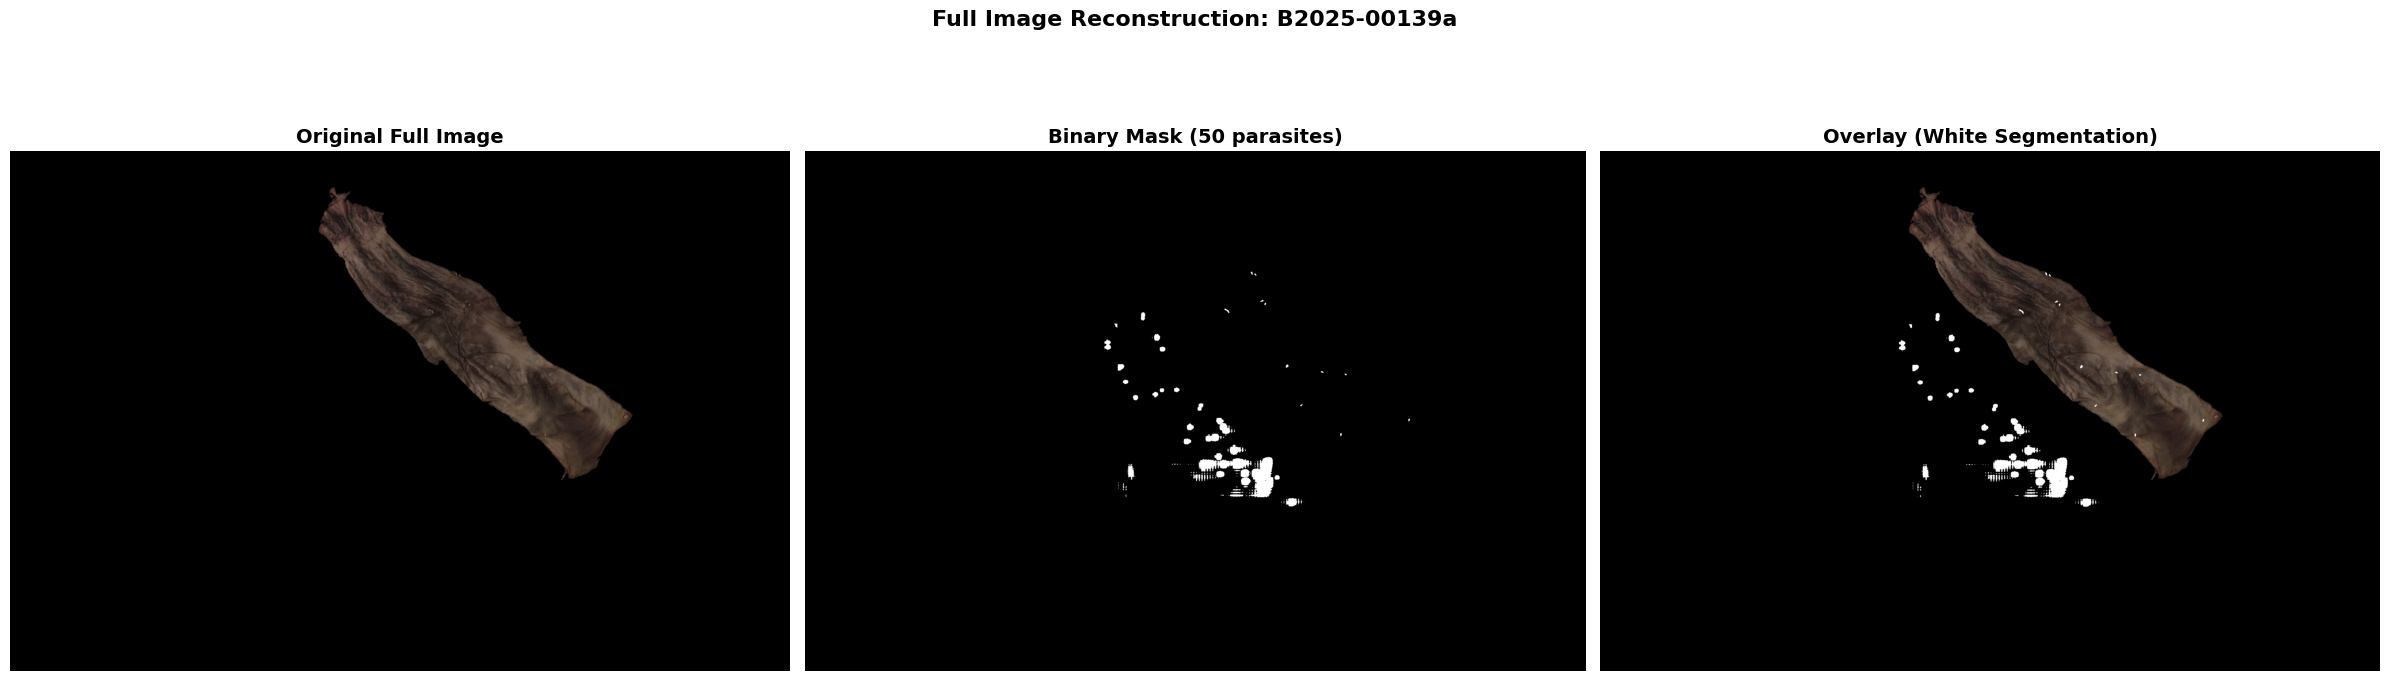


                                Image Statistics                                
--------------------------------------------------------------------------------
  Base Image ID: B2025-00139a
  Image size: 6000 x 4000 pixels
  Total parasites detected: 50
  Number of tiles: 15
  Segmentation coverage: 0.5694%
  Average parasite size: 2732.9 pixels
✓ Saved mask PNG to: /content/IA-PROJECT-PARASITE-REPO/segm_masks/B2025-00139a_mask.png
  PNG dimensions: 6000 x 4000 (W x H)
  Original dimensions: 6000 x 4000 (W x H)
  ✓ Dimensions match perfectly!
✓ Saved mask array to: /content/IA-PROJECT-PARASITE-REPO/segm_masks/B2025-00139a_mask.npy

PROCESS ALL IMAGES - SAVE ONLY SEGMENTATION MASKS (WHITE ON BLACK)
Found 5 unique images: B2025-00084n, B2025-00130c, B2025-00130e, B2025-00139a, B2025-00142a

Processing B2025-00084n...
Full image size will be: 6000 x 4000


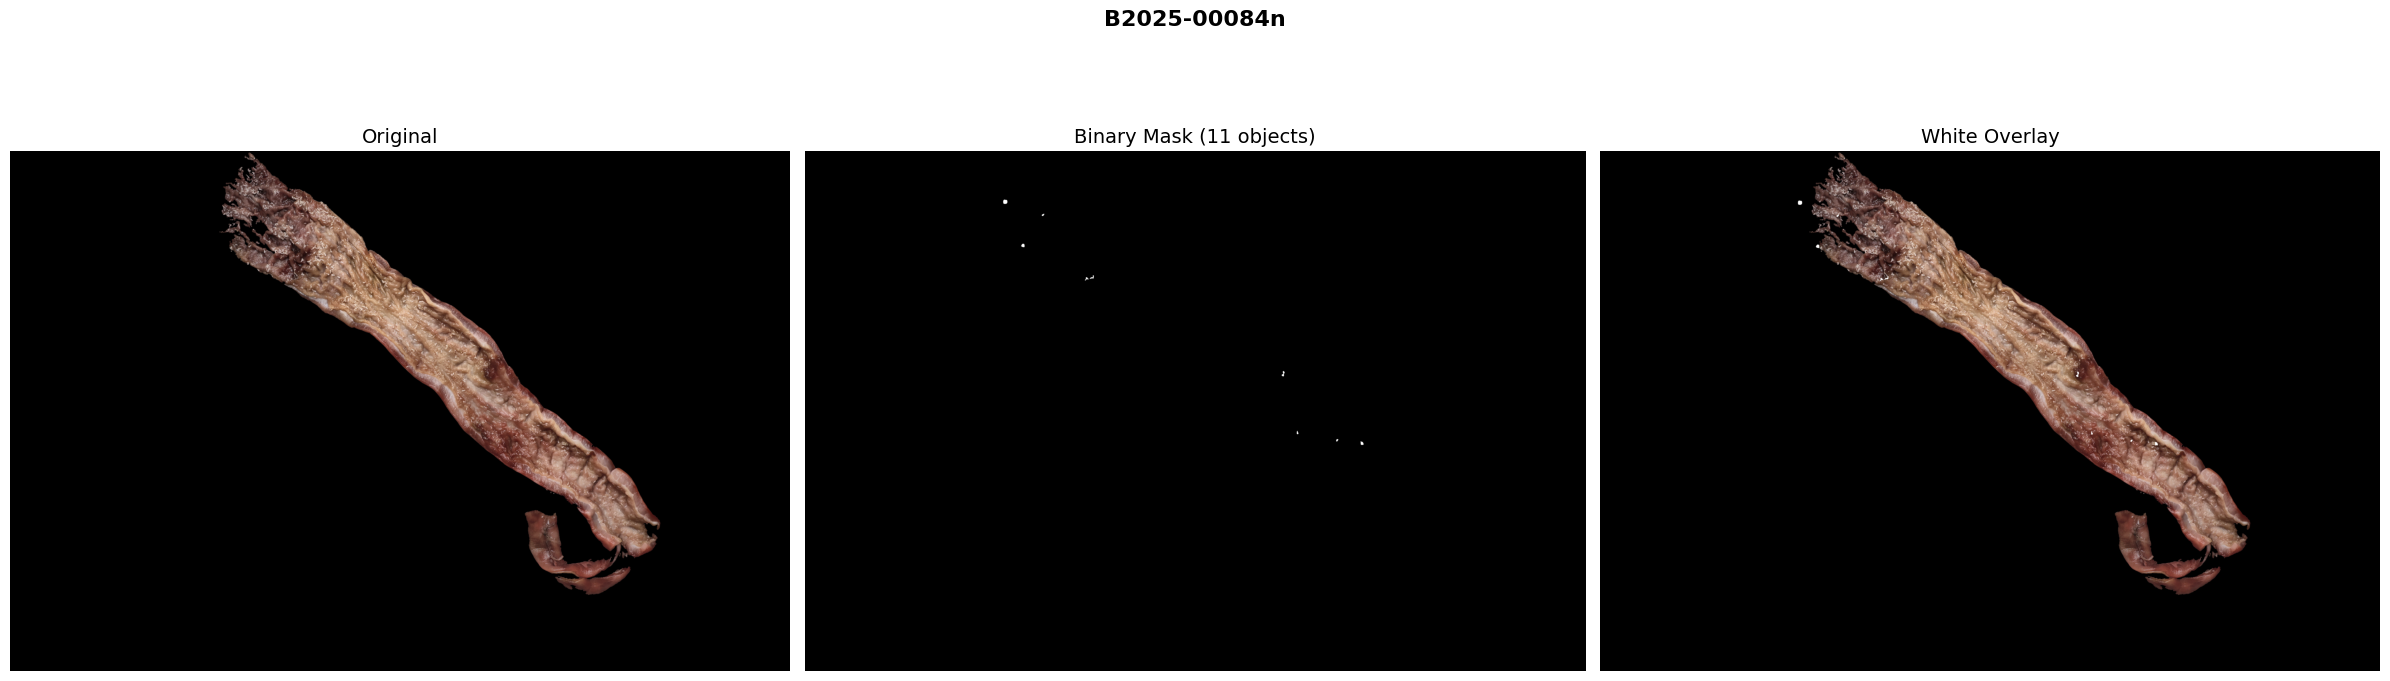

✓ Saved mask: /content/IA-PROJECT-PARASITE-REPO/segm_masks/B2025-00084n_mask.png [6000x4000]

Processing B2025-00130c...
Full image size will be: 6000 x 4000


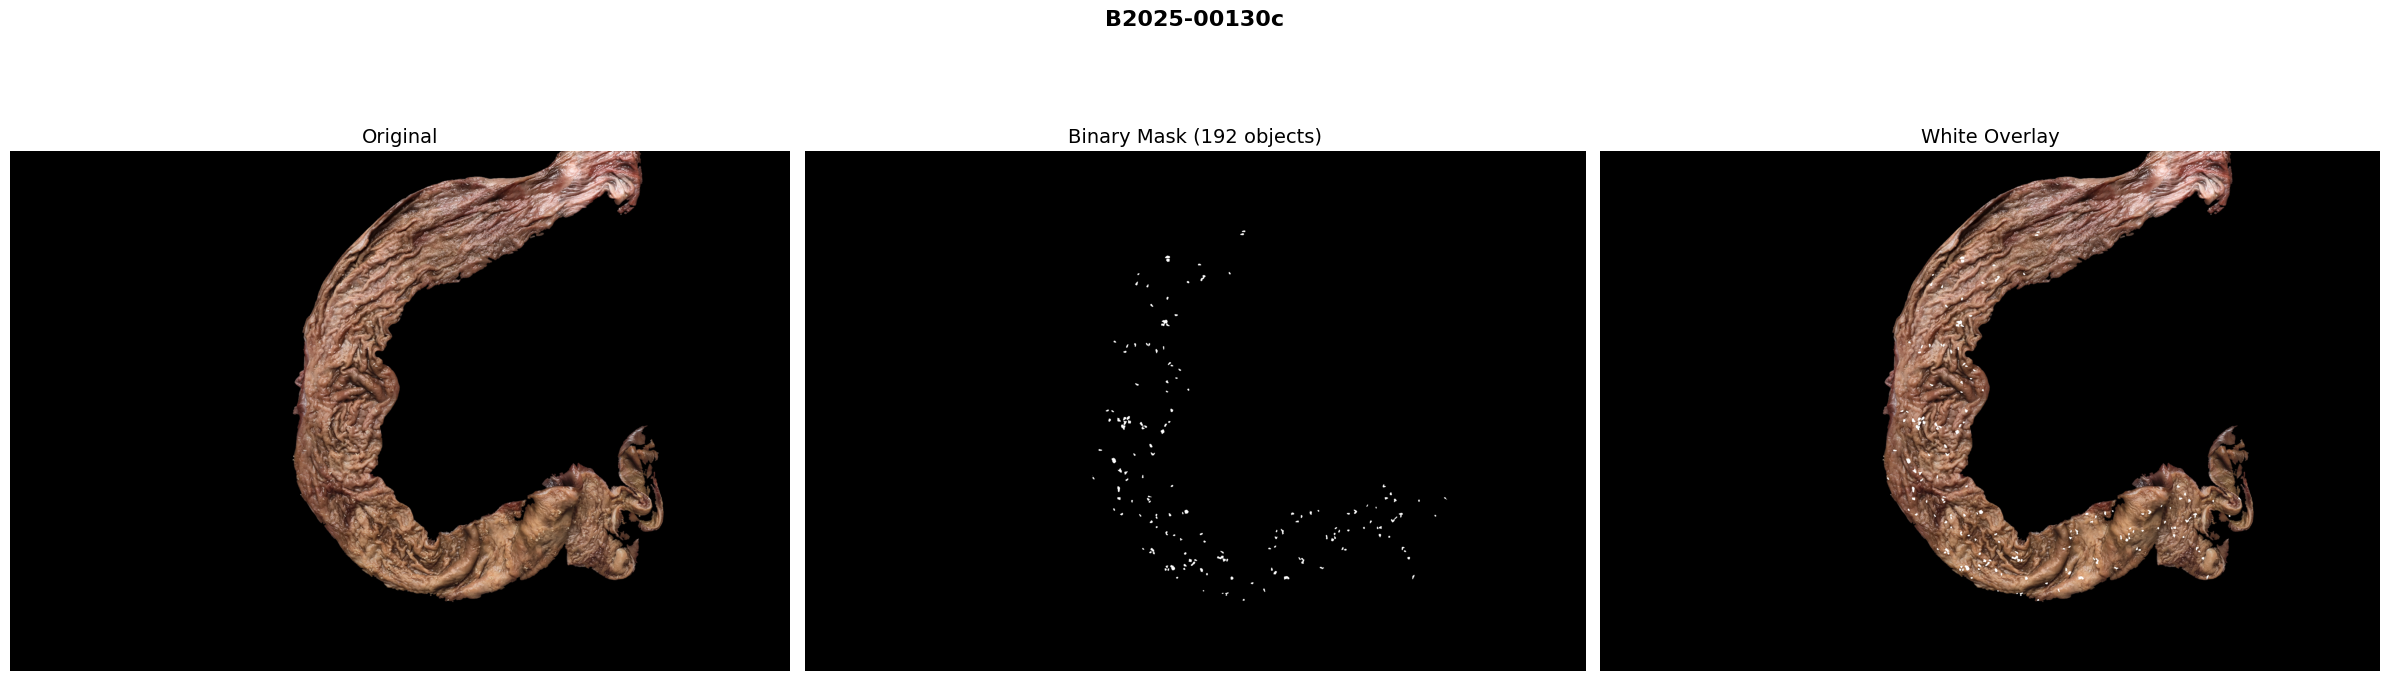

✓ Saved mask: /content/IA-PROJECT-PARASITE-REPO/segm_masks/B2025-00130c_mask.png [6000x4000]

Processing B2025-00130e...
Full image size will be: 6000 x 4000


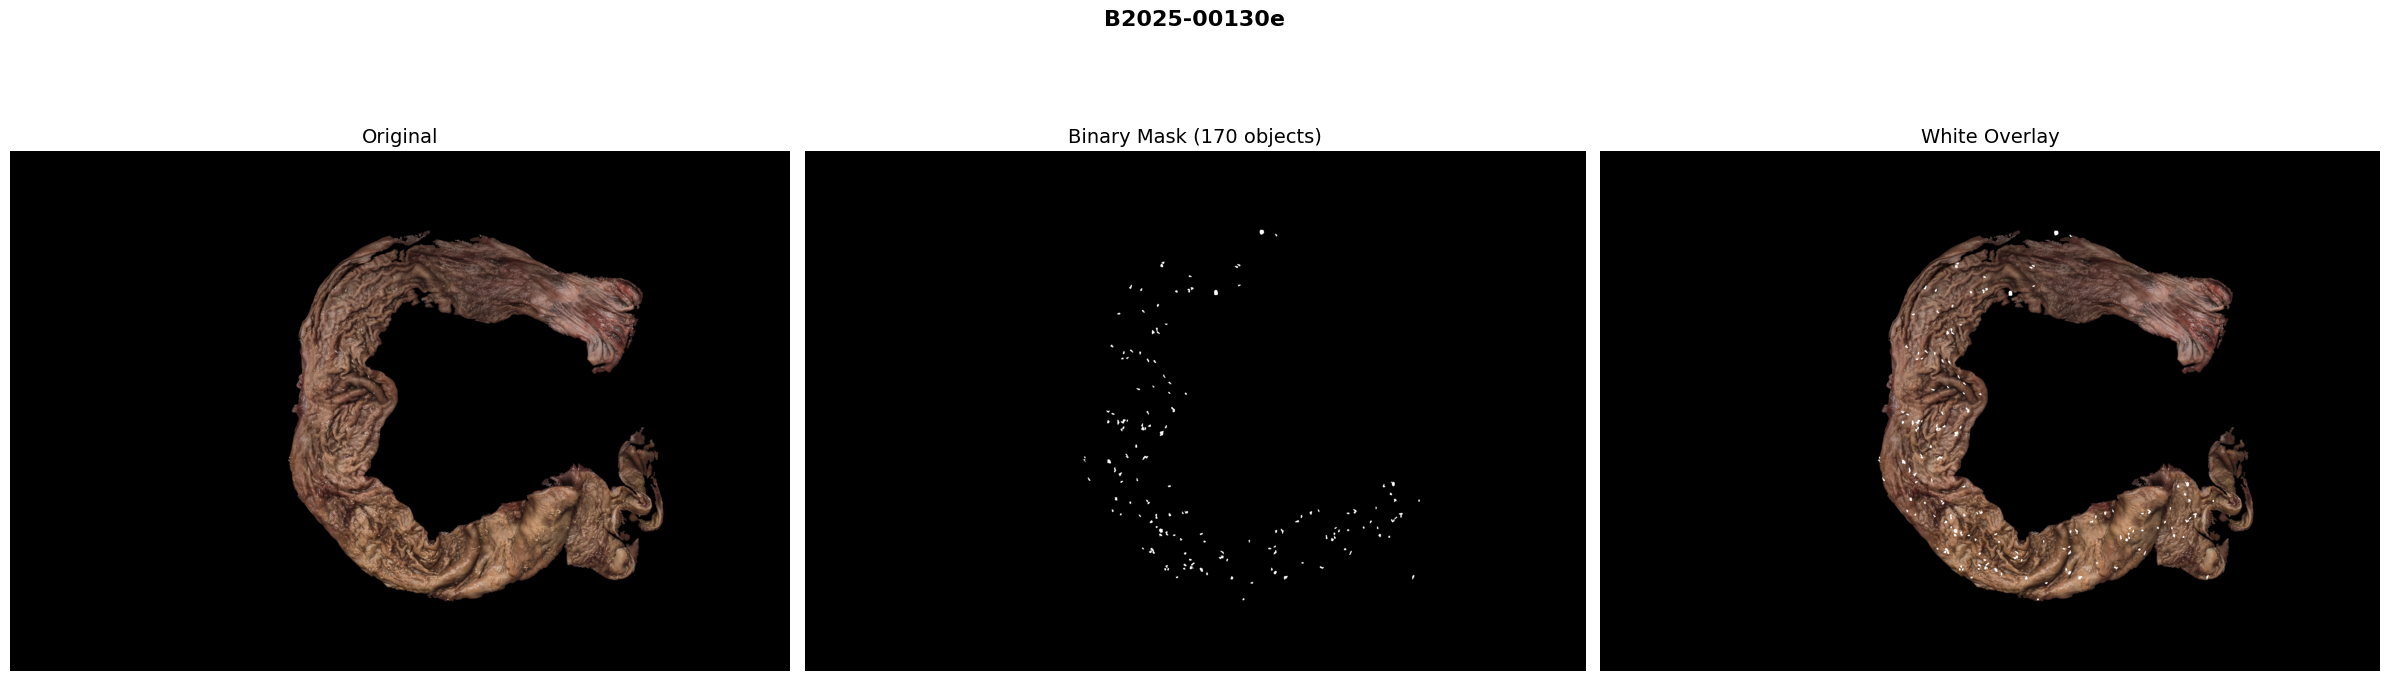

✓ Saved mask: /content/IA-PROJECT-PARASITE-REPO/segm_masks/B2025-00130e_mask.png [6000x4000]

Processing B2025-00139a...
Full image size will be: 6000 x 4000


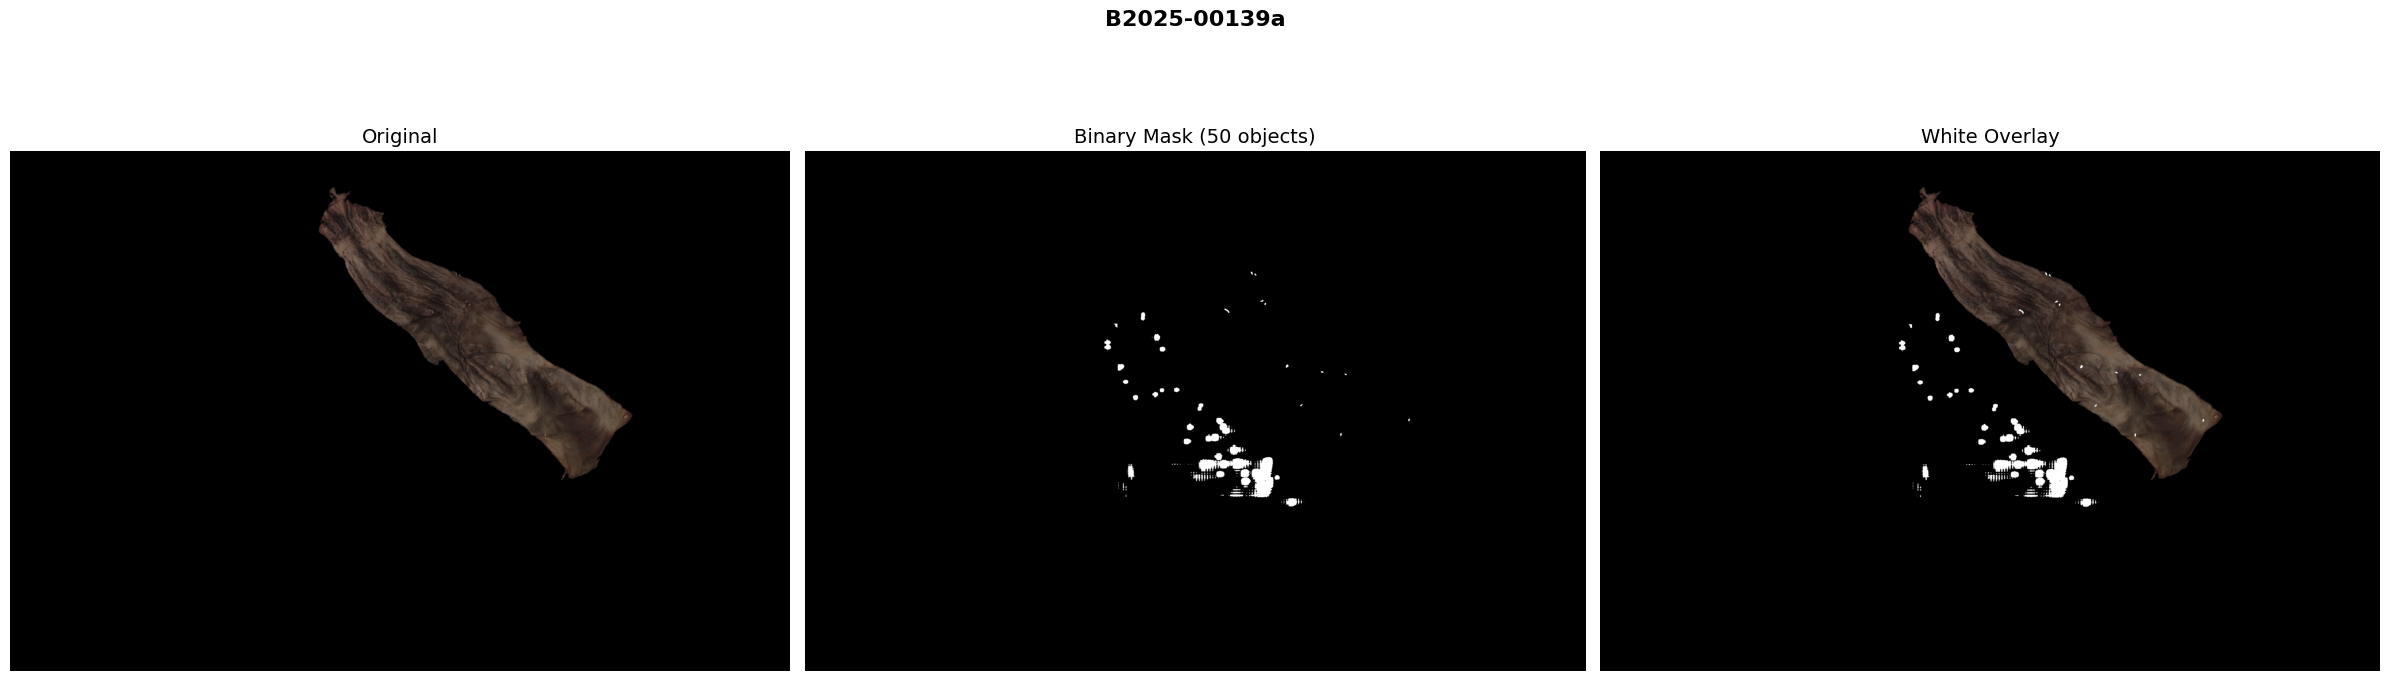

✓ Saved mask: /content/IA-PROJECT-PARASITE-REPO/segm_masks/B2025-00139a_mask.png [6000x4000]

Processing B2025-00142a...
Full image size will be: 6000 x 4000


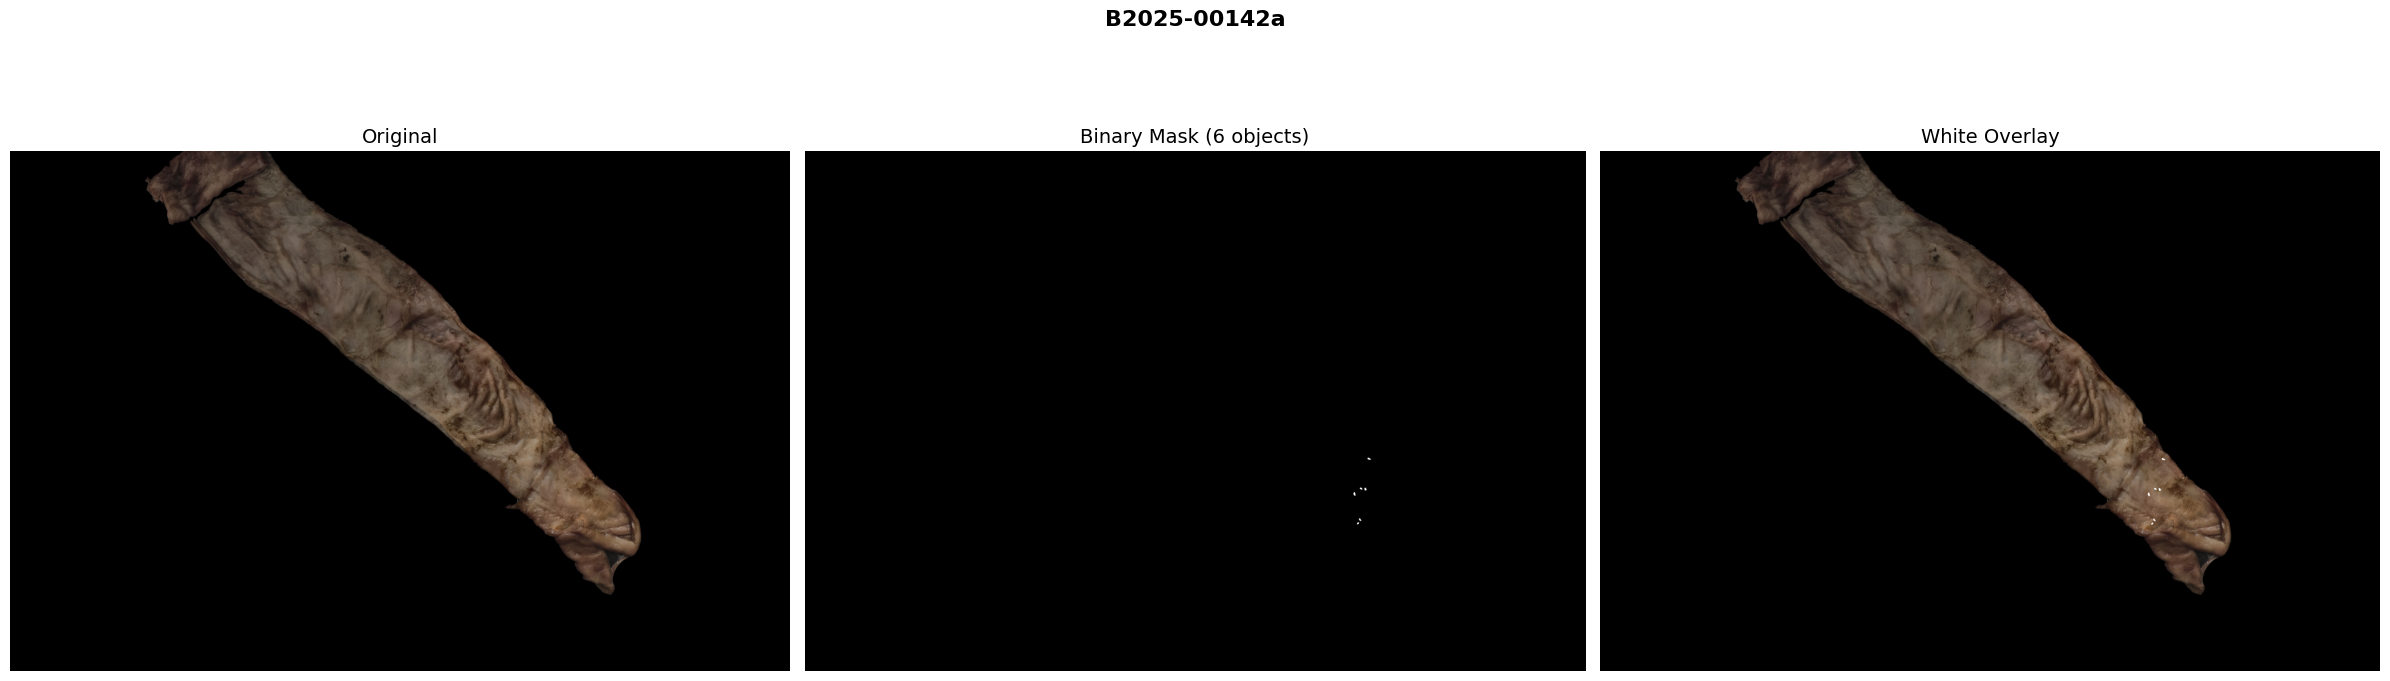

✓ Saved mask: /content/IA-PROJECT-PARASITE-REPO/segm_masks/B2025-00142a_mask.png [6000x4000]

✓ ALL SEGMENTATION MASKS SAVED TO: /content/IA-PROJECT-PARASITE-REPO/segm_masks
  - .npy files: NumPy arrays with integer labels (one per parasite)
  - .png files: Binary masks (white = parasites, black = background)


In [9]:
"""
Reconstruction using all_tiles instead of dataset_tiles
MODIFIED: Saves masks as PNG with WHITE segmentation overlay
"""

# ==============================================================================
# FULL IMAGE RECONSTRUCTION AND VISUALIZATION
# ==============================================================================

output_dir = "/content/IA-PROJECT-PARASITE-REPO/segm_masks"
def reconstruct_full_image_with_mask_fixed(all_tiles, dataset_tiles, base_image_id):
    """
    Reconstruct the full image and mask from tiles.
    Uses all_tiles for global_bbox and dataset_tiles for saved paths.
    """

    # Filter tiles for this image from both sources
    tiles_with_bbox = [t for t in all_tiles if t['base_image_id'] == base_image_id]
    tiles_with_paths = [t for t in dataset_tiles if t['base_image_id'] == base_image_id]

    if len(tiles_with_bbox) == 0 or len(tiles_with_paths) == 0:
        print(f"No tiles found for {base_image_id}")
        return None, None

    # Create mapping from tile_id to global_bbox
    bbox_map = {t['image_id']: t['global_bbox'] for t in tiles_with_bbox}

    # Determine full image dimensions
    max_h = max_w = 0
    for tile in tiles_with_bbox:
        x1, y1, x2, y2 = tile['global_bbox']
        max_h = max(max_h, y2)
        max_w = max(max_w, x2)

    print(f"Full image size will be: {max_w} x {max_h}")

    # Initialize arrays
    first_img = cv2.imread(tiles_with_paths[0]['image_path'])
    channels = first_img.shape[2]

    full_image = np.zeros((max_h, max_w, channels), dtype=np.uint8)
    full_mask = np.zeros((max_h, max_w), dtype=np.int32)

    # Track labels for uniqueness
    current_label = 1

    # Place each tile
    for tile in tiles_with_paths:
        tile_id = tile['image_id']

        # Get global_bbox from mapping
        if tile_id not in bbox_map:
            print(f"Warning: No bbox found for {tile_id}, skipping")
            continue

        x1, y1, x2, y2 = bbox_map[tile_id]

        # Load tile data
        tile_img = cv2.imread(tile['image_path'])
        tile_mask = np.load(tile['mask_path'])

        # Check dimensions match
        expected_h, expected_w = y2 - y1, x2 - x1
        actual_h, actual_w = tile_img.shape[:2]

        if expected_h != actual_h or expected_w != actual_w:
            print(f"Warning: Size mismatch for {tile_id}")
            print(f"  Expected: {expected_w}x{expected_h}, Got: {actual_w}x{actual_h}")
            # Adjust bbox to match actual size
            y2 = y1 + actual_h
            x2 = x1 + actual_w

        # Place image
        full_image[y1:y2, x1:x2] = tile_img

        # Relabel mask to avoid conflicts
        unique_labels = np.unique(tile_mask)
        unique_labels = unique_labels[unique_labels > 0]

        relabeled_mask = np.zeros_like(tile_mask)
        for old_label in unique_labels:
            relabeled_mask[tile_mask == old_label] = current_label
            current_label += 1

        # Place mask (only on background pixels)
        mask_region = full_mask[y1:y2, x1:x2]
        mask_region[relabeled_mask > 0] = relabeled_mask[relabeled_mask > 0]
        full_mask[y1:y2, x1:x2] = mask_region

    full_image_rgb = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)
    return full_image_rgb, full_mask


# ============================================================================
# MAIN VISUALIZATION
# ============================================================================

if len(dataset_tiles) > 0:
    print("\n" + "="*80)
    print("FULL IMAGE RECONSTRUCTION - SHOWING COMPLETE IMAGE WITH OVERLAY")
    print("="*80)

    first_base_id = dataset_tiles[0]['base_image_id']
    print(f"\nReconstructing: {first_base_id}")

    # Check if all_tiles exists
    try:
        # Reconstruct using BOTH all_tiles and dataset_tiles
        full_img, full_mask = reconstruct_full_image_with_mask_fixed(
            all_tiles, dataset_tiles, first_base_id
        )
    except NameError:
        print("\nERROR: 'all_tiles' variable not found!")
        print("You need to keep the 'all_tiles' variable from earlier in the pipeline.")
        print("Make sure you don't delete or overwrite it after creating tiles.")
        full_img, full_mask = None, None

    if full_img is not None and full_mask is not None:
        # Create WHITE overlay
        overlay = full_img.copy()
        overlay[full_mask > 0] = [255, 255, 255]  # White color for all detected parasites

        num_objects = full_mask.max()

        # Create visualization (3-panel for display)
        fig, axes = plt.subplots(1, 3, figsize=(24, 8))

        # Original full image
        axes[0].imshow(full_img)
        axes[0].set_title('Original Full Image', fontsize=14, fontweight='bold')
        axes[0].axis('off')

        # Binary mask (white on black)
        binary_mask = (full_mask > 0).astype(np.uint8) * 255
        axes[1].imshow(binary_mask, cmap='gray')
        axes[1].set_title(f'Binary Mask ({num_objects} parasites)',
                          fontsize=14, fontweight='bold')
        axes[1].axis('off')

        # Overlay with white
        axes[2].imshow(overlay)
        axes[2].set_title('Overlay (White Segmentation)',
                          fontsize=14, fontweight='bold')
        axes[2].axis('off')

        plt.suptitle(f'Full Image Reconstruction: {first_base_id}',
                     fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.show()

        # Print statistics
        print(f"\n{'Image Statistics':^80}")
        print("-"*80)
        print(f"  Base Image ID: {first_base_id}")
        print(f"  Image size: {full_img.shape[1]} x {full_img.shape[0]} pixels")
        print(f"  Total parasites detected: {num_objects}")

        # Count tiles used
        image_tiles = [t for t in dataset_tiles if t['base_image_id'] == first_base_id]
        print(f"  Number of tiles: {len(image_tiles)}")

        # Calculate coverage
        total_pixels = full_img.shape[0] * full_img.shape[1]
        mask_pixels = np.sum(full_mask > 0)
        coverage = (mask_pixels / total_pixels) * 100
        print(f"  Segmentation coverage: {coverage:.4f}%")
        if num_objects > 0:
            print(f"  Average parasite size: {mask_pixels / num_objects:.1f} pixels")
        print("="*80)

        # Save ONLY the binary mask as PNG - white on black background
        mask_png_path = os.path.join(output_dir, f'{first_base_id}_mask.png')

        # Create binary mask: 255 (white) where parasites are, 0 (black) elsewhere
        binary_mask = (full_mask > 0).astype(np.uint8) * 255

        # Save with OpenCV to preserve exact dimensions
        cv2.imwrite(mask_png_path, binary_mask)

        # Verify saved image dimensions
        saved_mask = cv2.imread(mask_png_path, cv2.IMREAD_GRAYSCALE)
        print(f"✓ Saved mask PNG to: {mask_png_path}")
        print(f"  PNG dimensions: {saved_mask.shape[1]} x {saved_mask.shape[0]} (W x H)")
        print(f"  Original dimensions: {full_img.shape[1]} x {full_img.shape[0]} (W x H)")

        if saved_mask.shape[:2] == full_img.shape[:2]:
            print(f"  ✓ Dimensions match perfectly!")
        else:
            print(f"  ⚠ Warning: Dimension mismatch!")

        # Also save the npy array if needed
        mask_npy_path = os.path.join(output_dir, f'{first_base_id}_mask.npy')
        np.save(mask_npy_path, full_mask)
        print(f"✓ Saved mask array to: {mask_npy_path}")

    else:
        print("\n Failed to reconstruct image.")
        print("Make sure the 'all_tiles' variable exists in your workspace.")

else:
    print("No tiles available for visualization")


# ==============================================================================
# OPTIONAL: Process ALL images and save ONLY masks
# ==============================================================================

print("\n" + "="*80)
print("PROCESS ALL IMAGES - SAVE ONLY SEGMENTATION MASKS (WHITE ON BLACK)")
print("="*80)

# Get unique base IDs
if len(dataset_tiles) > 0:
    base_ids = sorted(set([t['base_image_id'] for t in dataset_tiles]))
    print(f"Found {len(base_ids)} unique images: {', '.join(base_ids[:5])}")

    # Process all images
    for base_id in base_ids:
        print(f"\nProcessing {base_id}...")

        try:
            full_img, full_mask = reconstruct_full_image_with_mask_fixed(
                all_tiles, dataset_tiles, base_id
            )

            if full_img is not None:
                # Create WHITE overlay
                overlay = full_img.copy()
                overlay[full_mask > 0] = [255, 255, 255]

                # Display 3-panel view
                fig, axes = plt.subplots(1, 3, figsize=(24, 8))

                axes[0].imshow(full_img)
                axes[0].set_title('Original', fontsize=14)
                axes[0].axis('off')

                # Binary mask visualization
                binary_mask = (full_mask > 0).astype(np.uint8) * 255
                axes[1].imshow(binary_mask, cmap='gray')
                axes[1].set_title(f'Binary Mask ({full_mask.max()} objects)', fontsize=14)
                axes[1].axis('off')

                axes[2].imshow(overlay)
                axes[2].set_title('White Overlay', fontsize=14)
                axes[2].axis('off')

                plt.suptitle(f'{base_id}', fontsize=16, fontweight='bold')
                plt.tight_layout()
                plt.show()

                # Save binary mask as PNG - white on black
                mask_png_path = os.path.join(output_dir, f'{base_id}_mask.png')
                binary_mask = (full_mask > 0).astype(np.uint8) * 255
                cv2.imwrite(mask_png_path, binary_mask)

                # Also save npy if needed
                mask_npy_path = os.path.join(output_dir, f'{base_id}_mask.npy')
                np.save(mask_npy_path, full_mask)

                print(f"✓ Saved mask: {mask_png_path} [{full_mask.shape[1]}x{full_mask.shape[0]}]")

        except Exception as e:
            print(f"✗ Error processing {base_id}: {e}")

    print("\n" + "="*80)
    print(f"✓ ALL SEGMENTATION MASKS SAVED TO: {output_dir}")
    print("  - .npy files: NumPy arrays with integer labels (one per parasite)")
    print("  - .png files: Binary masks (white = parasites, black = background)")
    print("="*80)

---

## 8. Output Files

### Generated for each image:

#### 1. `.npy` files (NumPy arrays)
- **Format**: Integer array (same dimensions as original image)
- **Content**: Instance segmentation
  - `0` = background
  - `1, 2, 3, ...` = individual parasites
- **Use**: Machine learning, quantitative analysis

#### 2. `.png` files (Binary masks)
- **Format**: Grayscale image
- **Content**: Binary segmentation
  - `0` (black) = background
  - `255` (white) = all parasites combined
- **Use**: Visualization, overlay on original images

### Quality Assurance:
- Dimensions match original images exactly
- No information loss during tiling/reconstruction
- Each parasite maintains spatial accuracy

---

## Summary

This pipeline:
- Preprocesses large museum specimen images
- Handles background removal while preserving dimensions
- Segments individual parasites using SAM
- Reconstructs full-resolution segmentation masks
- Exports results in multiple formats

**Next steps**: Use these masks for parasite counting, morphological analysis, or training custom detection models!